In [2]:
from langgraph.graph import START, END, StateGraph
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from IPython.display import Image, display, Markdown
from typing import TypedDict, List
import operator
import os

print(" All imports successful")

 All imports successful


In [3]:
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

if not openai_api_key:
    raise ValueError("OPENAI_API_KEY not found in .env file!")

print(" API key loaded")

 API key loaded


In [4]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.7,
    api_key=openai_api_key
)

print(f" LLM initialized: {llm.model_name}")

 LLM initialized: gpt-4o-mini


In [5]:
class HybridState(TypedDict):
    """
    Combined state for Plan-Execute + Reflection hybrid pattern.
    Combines planning, execution, and reflection states.
    """

    input: str                   
    plan: List[str]              
    current_step: int            
    results: List[str]          

    draft: str                   
    critique: str               
    iterations: int              
    final_output: str           

print(" Hybrid state defined")

 Hybrid state defined


In [6]:
MAX_REFLECTIONS = 3  
print(f"Configuration: Max reflections = {MAX_REFLECTIONS}")

Configuration: Max reflections = 3


In [ ]:
def planner(state: HybridState) -> dict:
    """
    Create a step-by-step plan for the task.
    Takes user input and breaks it down into actionable steps.
    """
    print(" PLANNER: Creating step-by-step plan...")
    
    prompt = f"""You are a task planning expert. Create a detailed, actionable plan for this task:

TASK: {state['input']}

Create a numbered list of 3-5 specific, concrete steps that will accomplish this task.
Each step should be:
1. Clear and specific
2. Actionable (something that can be executed)
3. Sequentially logical
4. Comprehensive for the task

Format your response as a numbered list only."""
    
    response = llm.invoke([HumanMessage(content=prompt)])
    
  
    lines = response.content.split('\n')
    steps = []
    
    for line in lines:
        line = line.strip()
        
        if line and any(char.isdigit() for char in line[:3]) and '. ' in line:
  
            step_text = line.split('. ', 1)[1].strip()
            steps.append(step_text)
    
  
    if not steps:
      
        for line in lines:
            line = line.strip()
            if line and (line.startswith('- ') or line.startswith('* ') or line.startswith('1. ') or line.startswith('• ')):
                
                clean_line = line.replace('- ', '').replace('* ', '').replace('• ', '')
                if '. ' in clean_line and clean_line[0].isdigit():
                    clean_line = clean_line.split('. ', 1)[1]
                steps.append(clean_line)
    
    if not steps:
        steps = [response.content]
    
    print(f" PLAN CREATED ({len(steps)} steps):")
    for i, step in enumerate(steps, 1):
        print(f"  {i}. {step}")
    print()
    
    return {
        "plan": steps, 
        "current_step": 0,
        "results": []
    }

print(" Planner node defined")

 Planner node defined


In [ ]:
def executor(state: HybridState) -> dict:
    """
    Execute the current step in the plan.
    Simulates tool execution using the LLM.
    """
   
    if state["current_step"] >= len(state["plan"]):
        print(" EXECUTOR: All steps completed!\n")
        return {}
    
    current_step_text = state["plan"][state["current_step"]]
    step_number = state["current_step"] + 1
    
    print(f" EXECUTOR: Executing Step {step_number}/{len(state['plan'])}")
    print(f"   Step: {current_step_text}")
    
    previous_results = state.get("results", [])
    context = ""
    if previous_results:
        context = f"Previous results so far:\n" + "\n".join(previous_results)

    prompt = f"""Execute this step as part of a larger task:

ORIGINAL TASK: {state['input']}

{context}

CURRENT STEP TO EXECUTE: {current_step_text}

Provide the specific output or result of executing this step.
Be concrete and detailed in your response.
Focus only on completing this specific step."""
    
  
    response = llm.invoke([HumanMessage(content=prompt)])
    
    result = f"Step {step_number}: {current_step_text}\nResult: {response.content}"
    
    print(f"   ✓ Result obtained ({len(response.content)} characters)")
    print()
    
    return {
        "results": [result], 
        "current_step": step_number 
    }

print(" Executor node defined")

 Executor node defined


In [10]:
def generator(state: HybridState) -> dict:
    """
    Generate an initial draft by synthesizing all execution results.
    This creates the first version of the final output.
    """
    print(" GENERATOR: Synthesizing results into draft...")
    
    results_text = "\n".join(state.get("results", []))
    
    prompt = f"""Synthesize all these execution results into a cohesive, well-structured final response:

ORIGINAL TASK: {state['input']}

EXECUTION RESULTS FROM ALL STEPS:
{results_text}

Create a comprehensive, polished response that:
1. Directly addresses the original task
2. Integrates information from all execution steps
3. Is well-structured and easy to read
4. Provides value to someone asking this question

Your response should be the final answer to the original task, not a summary of the process."""
    
    response = llm.invoke([HumanMessage(content=prompt)])
    
    print(f"   ✓ Draft created ({len(response.content)} characters)")
    print()
    
    return {"draft": response.content}

print(" Generator node defined")

 Generator node defined


In [ ]:
def critic(state: HybridState) -> dict:
    """
    Critically evaluate the draft and provide constructive feedback.
    Determines if the draft needs refinement.
    """
    print(" CRITIC: Evaluating draft quality...")
    
    prompt = f"""You are a quality assurance expert. Critique this draft response:

ORIGINAL TASK: {state['input']}

DRAFT RESPONSE:
{state['draft']}

Evaluate this draft on:
1. Completeness - Does it fully address the original task?
2. Accuracy - Is the information correct and reliable?
3. Clarity - Is it easy to understand?
4. Organization - Is it well-structured?
5. Tone & Style - Is it appropriate for the audience?

Provide specific, actionable feedback. If the draft is excellent, start your response with:
"APPROVED: [brief explanation of why it's good]"

Otherwise, provide concrete suggestions for improvement.
Focus on the most important improvements needed."""
    
    response = llm.invoke([HumanMessage(content=prompt)])
    critique = response.content
    
   
    critique_preview = critique[:200] + "..." if len(critique) > 200 else critique
    print(f"   Critique preview: {critique_preview}")
    print()
    
    return {
        "critique": critique,
        "iterations": state.get("iterations", 0) + 1
    }

print(" Critic node defined")

 Critic node defined


In [12]:
def refiner(state: HybridState) -> dict:
    """
    Refine the draft based on the critique.
    Creates an improved version of the draft.
    """
    iteration = state.get("iterations", 1)
    print(f" REFINER: Improving draft (iteration {iteration})...")
    
    prompt = f"""Improve this draft based on the critique:

ORIGINAL TASK: {state['input']}

CURRENT DRAFT:
{state['draft']}

CRITIQUE TO ADDRESS:
{state['critique']}

Create an improved version that:
1. Addresses all points from the critique
2. Maintains the good qualities of the current draft
3. Is even better at fulfilling the original task

Your response should be the improved draft only."""
    
    response = llm.invoke([HumanMessage(content=prompt)])
    
    print(f" Refined draft created")
    print()
    
    return {"draft": response.content}

print(" Refiner node defined")

 Refiner node defined


In [ ]:
def finalizer(state: HybridState) -> dict:
    """
    Finalize the process and prepare the final output.
    """
    print(" FINALIZER: Preparing final output...")
    
    
    final_output = state["draft"]
    
    return {"final_output": final_output}

print(" Finalizer node defined")

 Finalizer node defined


In [ ]:
def should_continue_execution(state: HybridState) -> str:
    """
    Determine if we should continue executing steps or move to generation.
    """
    if state["current_step"] < len(state["plan"]):
        return "executor"
    return "generator"

def should_refine(state: HybridState) -> str:
    """
    Determine if the draft needs refinement or is ready for finalization.
    """
    critique = state.get("critique", "").upper()

    if critique.startswith("APPROVED:"):
        print("    Critic APPROVED the draft!")
        return "finalizer"
    
   
    if state.get("iterations", 0) >= MAX_REFLECTIONS:
        print(f" Maximum reflection iterations ({MAX_REFLECTIONS}) reached")
        return "finalizer"
    
    return "refiner"

print("Routing functions defined")

Routing functions defined


Building hybrid agent graph...
 All nodes added to graph
 All edges added to graph
 Hybrid agent compiled successfully!


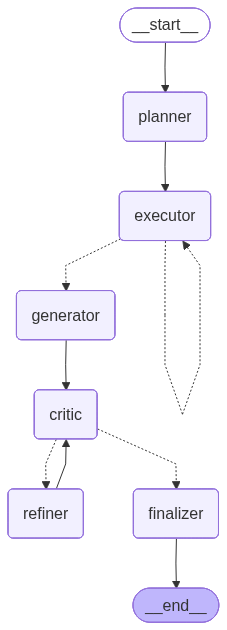

In [16]:
print("Building hybrid agent graph...")

hybrid_builder = StateGraph(HybridState)

hybrid_builder.add_node("planner", planner)
hybrid_builder.add_node("executor", executor)
hybrid_builder.add_node("generator", generator)
hybrid_builder.add_node("critic", critic)
hybrid_builder.add_node("refiner", refiner)
hybrid_builder.add_node("finalizer", finalizer)

print(" All nodes added to graph")

hybrid_builder.add_edge(START, "planner")
hybrid_builder.add_edge("planner", "executor")

hybrid_builder.add_conditional_edges(
    "executor",
    should_continue_execution,
    {
        "executor": "executor",  
        "generator": "generator"  
    }
)

hybrid_builder.add_edge("generator", "critic")

hybrid_builder.add_conditional_edges(
    "critic", 
    should_refine,
    {
        "refiner": "refiner",    
        "finalizer": "finalizer" 
    }
)


hybrid_builder.add_edge("refiner", "critic")
hybrid_builder.add_edge("finalizer", END)

print(" All edges added to graph")


hybrid_agent = hybrid_builder.compile()

print(" Hybrid agent compiled successfully!")


display(Image(hybrid_agent.get_graph().draw_mermaid_png()))

In [17]:
def format_output_as_markdown(text: str) -> None:
    """Display text as formatted markdown."""
    display(Markdown(text))

def test_hybrid_agent(task: str, verbose: bool = True):
    """
    Test the hybrid agent with a given task.
    
    Args:
        task: The task/query for the agent
        verbose: Whether to print detailed execution logs
    """
    print("=" * 80)
    print(" TESTING HYBRID PLAN-EXECUTE + REFLECTION AGENT")
    print("=" * 80)
    print(f" TASK: {task}")
    print("=" * 80)
    
  
    initial_state = {
        "input": task,
        "plan": [],
        "current_step": 0,
        "results": [],
        "draft": "",
        "critique": "",
        "iterations": 0,
        "final_output": ""
    }
    
 
    print("\n Starting agent execution...\n")
    result = hybrid_agent.invoke(initial_state)
    
    print("\n" + "=" * 80)
    print(" EXECUTION COMPLETE")
    print("=" * 80)
    
    print("\n FINAL PLAN:")
    for i, step in enumerate(result.get("plan", []), 1):
        print(f"  {i}. {step}")
   
    print(f"\n EXECUTION SUMMARY:")
    print(f"  • Plan steps created: {len(result.get('plan', []))}")
    print(f"  • Steps executed: {result.get('current_step', 0)}")
    print(f"  • Execution results collected: {len(result.get('results', []))}")
    print(f"  • Reflection iterations: {result.get('iterations', 0)}")
    

    print("\n" + "=" * 80)
    print(" FINAL OUTPUT")
    print("=" * 80)
    
    final_output = result.get("final_output", "No output generated")
    format_output_as_markdown(final_output)
    
    print("\n" + "=" * 80)
    print(" TEST COMPLETE")
    print("=" * 80)
    
    return result

In [18]:
#  Test Case 1: Research and synthesis task
test_task_1 = "Research the benefits of Python programming, create a summary, and make it beginner-friendly"

print("Test 1: Research and synthesis task")
print("-" * 50)
result_1 = test_hybrid_agent(test_task_1)

Test 1: Research and synthesis task
--------------------------------------------------
 TESTING HYBRID PLAN-EXECUTE + REFLECTION AGENT
 TASK: Research the benefits of Python programming, create a summary, and make it beginner-friendly

 Starting agent execution...

 PLANNER: Creating step-by-step plan...
📋 PLAN CREATED (5 steps):
  1. **Gather Resources**: Identify and collect at least 5 credible sources on the benefits of Python programming. These can include articles, blog posts, academic papers, and videos. Ensure that the sources are beginner-friendly and cover various aspects such as versatility, ease of learning, community support, and job opportunities.
  2. **Summarize Key Benefits**: Read through the gathered resources and extract key points regarding the benefits of Python programming. Create a bullet-point list highlighting at least 6-8 major benefits, ensuring that each point is clear and concise for beginners.
  3. **Draft the Summary**: Write a 300-500 word summary that i

# The Benefits of Python Programming for Beginners

## Introduction  
Python programming is becoming increasingly popular among beginners, and for good reason. Whether you're interested in starting a career in technology, automating daily tasks, or simply learning a new skill, Python offers numerous advantages that make it an excellent choice for newcomers.

## 1. Easy to Learn  
- **Clear Syntax**: Python uses simple, readable syntax that is easy to understand.  
- **Example**: To display “Hello, World!”, you simply write:  
  ```python
  print("Hello, World!")
  ```
  *This line of code displays the message "Hello, World!" on the screen.*
- **Educational Resources**: A wealth of online courses, interactive platforms like Codecademy, and tutorials are available, specifically designed for beginners to help you learn at your own pace.

## 2. Very Versatile  
- **Multiple Applications**: Python can be used in various fields, including:
  - Web development
  - Data analysis
  - Artificial intelligence
  - Task automation
  - Scientific research
- *While Python is versatile, certain tasks may require specific libraries or frameworks that beginners can explore after mastering the basics of Python.*

## 3. Strong Community Support  
- **Access to Resources**: A vast array of online forums, tutorials, and documentation is available.  
- **Peer Assistance**: Chances are, if you encounter a problem, someone has already solved it and shared their solution online. Websites like Stack Overflow are great places to seek help.

## 4. Helpful Libraries and Frameworks  
- **Time-Saving Tools**: Python boasts a rich ecosystem of libraries and frameworks, such as:
  - **Data Handling**: Libraries like NumPy and Pandas for data manipulation.
  - **Web Development**: Frameworks like Flask and Django to simplify web app creation.
- *For beginners, understanding that libraries are pre-written code collections that help simplify programming tasks can be empowering. Focus on mastering Python basics before diving into these tools.*

## 5. High Demand for Jobs  
- **Career Opportunities**: Python developers are sought after in various sectors, including:
  - Data science
  - Web development
  - Automation
- *According to recent statistics, Python consistently ranks among the top programming languages in job postings, with roles such as data scientist and web developer. Salaries for Python developers often range from $60,000 to over $120,000 annually, depending on experience and location.*

## 6. Works on Different Operating Systems  
- **Cross-Platform Compatibility**: Python runs seamlessly on Windows, macOS, and Linux, allowing for flexibility in development environments.

## 7. Great for Prototyping  
- **Quick Development**: Python’s simplicity allows you to quickly turn ideas into working applications, making it ideal for rapid prototyping.

## 8. Perfect for Automation  
- **Boost Productivity**: Python can automate repetitive tasks, such as:
  - Data entry
  - File management
  - Software testing
- *This ability to automate mundane tasks can free up time for more creative projects.*

## 9. Common Challenges and Solutions  
- **Initial Complexity**: Beginners may feel overwhelmed by the vastness of Python’s capabilities.  
  - *Tip*: Focus on small, manageable projects to build confidence and gradually expand your knowledge.
- **Debugging**: Encountering errors is part of the learning process.  
  - *Tip*: Use debugging tools and online communities for support when you get stuck. Remember, every coder faces challenges—embrace them as part of your learning journey!

## Conclusion  
Python programming offers a wealth of advantages that make it an ideal starting point for beginners. From its user-friendly structure and wide range of applications to robust community support and strong job market demand, Python opens the door to numerous opportunities in the tech world. If you're considering diving into programming, Python is undoubtedly a fantastic language to begin with! Start your journey today by enrolling in an online course or tackling a small project, like building a simple calculator or automating a task you do regularly, to experience the joy of coding firsthand.

---

### Visual Enhancements (Optional)  
To enhance understanding, consider creating an infographic summarizing these benefits for quick reference. A simple layout could include icons representing each benefit, such as a book for learning, a globe for versatility, and a laptop for job opportunities.

---

### Document Accessibility  
For your convenience, the complete summary is available in both Word (DOCX) and PDF formats. Files are named as follows for easy identification:
- `Benefits_of_Python_Programming_Beginners.docx`
- `Benefits_of_Python_Programming_Beginners.pdf`

This comprehensive overview is now ready for presentation and can be easily shared with anyone interested in understanding the benefits of Python programming.


 TEST COMPLETE


In [19]:
#  Test Case 2: Creative writing task
test_task_2 = "Create a guide for learning machine learning. Include key concepts, recommended resources, and a 30-day study plan."

print("\n\nTest 2: Creative writing task")
print("-" * 50)
result_2 = test_hybrid_agent(test_task_2)



Test 2: Creative writing task
--------------------------------------------------
 TESTING HYBRID PLAN-EXECUTE + REFLECTION AGENT
 TASK: Create a guide for learning machine learning. Include key concepts, recommended resources, and a 30-day study plan.

 Starting agent execution...

 PLANNER: Creating step-by-step plan...


APIConnectionError: Connection error.

In [20]:
#  Test Case 3: Technical explanation task
test_task_3 = "Explain how large language models work to a non-technical audience. Use analogies and simple language."

print("\n\nTest 3: Technical explanation task")
print("-" * 50)
result_3 = test_hybrid_agent(test_task_3)



Test 3: Technical explanation task
--------------------------------------------------
 TESTING HYBRID PLAN-EXECUTE + REFLECTION AGENT
 TASK: Explain how large language models work to a non-technical audience. Use analogies and simple language.

 Starting agent execution...

 PLANNER: Creating step-by-step plan...


APIConnectionError: Connection error.

In [21]:
def debug_agent_execution(task: str):
    """
    Run the agent and show detailed step-by-step execution.
    Useful for understanding the agent's reasoning process.
    """
    print("🔍 DEBUG MODE: Detailed execution trace")
    print("=" * 80)
    print(f"Task: {task}")
    print("=" * 80)
    

    state = {
        "input": task,
        "plan": [],
        "current_step": 0,
        "results": [],
        "draft": "",
        "critique": "",
        "iterations": 0,
        "final_output": ""
    }
    
    print("\n 1️. PLANNER OUTPUT:")
    state.update(planner(state))
    
    print("\n 2. EXECUTOR OUTPUTS:")
    while state["current_step"] < len(state["plan"]):
        state.update(executor(state))
    
    print("\n 3️. GENERATOR OUTPUT:")
    state.update(generator(state))
    
    print("\n 4. CRITIC/REFINER LOOP:")
    reflection_count = 0
    while reflection_count < MAX_REFLECTIONS:
        reflection_count += 1
        print(f"\n   Reflection iteration {reflection_count}:")
        
   
        state.update(critic(state))
        
    
        if state["critique"].upper().startswith("APPROVED:"):
            print("   → Draft approved!")
            break
        
      
        state.update(refiner(state))
    
    print("\n 5️. FINAL OUTPUT:")
    state.update(finalizer(state))
    
    print("\n" + "=" * 80)
    print(" FINAL STATE SUMMARY:")
    print("=" * 80)
    print(f"Plan steps: {len(state['plan'])}")
    print(f"Steps executed: {state['current_step']}")
    print(f"Results collected: {len(state['results'])}")
    print(f"Reflection iterations: {state['iterations']}")
    print(f"Final output length: {len(state['final_output'])} characters")
    
    return state

In [22]:

debug_task = "Explain the water cycle in simple terms for a 5th grader"
debug_result = debug_agent_execution(debug_task)

🔍 DEBUG MODE: Detailed execution trace
Task: Explain the water cycle in simple terms for a 5th grader

 1️. PLANNER OUTPUT:
 PLANNER: Creating step-by-step plan...


APIConnectionError: Connection error.

In [ ]:
def analyze_agent_performance(results_list):
    """
    Analyze the performance of the hybrid agent across multiple tests.
    """
    print(" AGENT PERFORMANCE ANALYSIS")
    print("=" * 80)
    
    for i, result in enumerate(results_list, 1):
        print(f"\nTest {i}:")
        print(f"  • Plan complexity: {len(result.get('plan', []))} steps")
        print(f"  • Execution thoroughness: {len(result.get('results', []))} results")
        print(f"  • Reflection depth: {result.get('iterations', 0)} iterations")
        print(f"  • Output quality: {len(result.get('final_output', ''))} characters")
    
    if results_list:
        avg_steps = sum(len(r.get('plan', [])) for r in results_list) / len(results_list)
        avg_iterations = sum(r.get('iterations', 0) for r in results_list) / len(results_list)
        avg_length = sum(len(r.get('final_output', '')) for r in results_list) / len(results_list)
        
        print("\n" + "-" * 80)
        print("📈 AVERAGE PERFORMANCE:")
        print(f"  • Average plan steps: {avg_steps:.1f}")
        print(f"  • Average reflection iterations: {avg_iterations:.1f}")
        print(f"  • Average output length: {avg_length:.1f} characters")

test_results = [result_1, result_2, result_3]
analyze_agent_performance(test_results)

In [ ]:
print(" PATTERN COMPARISON: Hybrid vs Individual Patterns")
print("=" * 80)

print("\n1. Hybrid Plan-Execute + Reflection:")
print("      Pros:")
print("     • Structured planning prevents getting lost")
print("     • Reflection ensures high-quality output")
print("     • Transparent execution process")
print("     • Balanced approach (planning + quality control)")
print("     Cons:")
print("     • More complex to implement")
print("     • Higher token usage (multiple LLM calls)")
print("     • Slower than simpler patterns")

print("\n2. Pure Plan-Execute (without reflection):")
print("      Pros:")
print("     • Very predictable execution")
print("     • Good for linear, well-defined tasks")
print("     • Lower token usage")
print("      Cons:")
print("     • No quality assurance loop")
print("     • Can produce mediocre outputs")
print("     • No self-correction")

print("\n3. Pure Reflection (without planning):")
print("     Pros:")
print("     • High-quality outputs through iteration")
print("     • Self-correcting and improving")
print("      Cons:")
print("     • Can get stuck on complex multi-step tasks")
print("     • No structured approach to complex problems")
print("     • May refine the wrong aspects without planning")

print("\n" + "=" * 80)
print("🎯 WHEN TO USE HYBRID PATTERN:")
print("  • Complex tasks requiring both structure AND quality")
print("  • Content creation (blogs, guides, documentation)")
print("  • Educational material generation")
print("  • Research synthesis tasks")
print("  • When output quality is critical but task is complex")